In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from da.l63 import gen_l63
from da.scheme import rk4, euler

# Estimate "Maximum Lyapunov exponent" by ensemble simulation
Let $ (\mathcal{U}, |\cdot|) $ be a Hilbert space.

Assume a dynamics $ \Psi_t: \mathcal{U} \rightarrow \mathcal{U} $ has a compact global attractor $ \mathcal{A} $, i.e.,

$ |\Psi_t(u)| \le \exists \rho \quad \forall u \in \mathcal{A}, t > 0 $.

Assume $\exists \beta > 0 $ s.t.

$ |u_t - v_t| \le e^{\beta t} |u_0 - v_0|, \quad \forall u_0 \in \mathcal{A}, v_0 \in \mathcal{U}, t > 0 $.

In [21]:
# params
s = 9
b = 8/3
r = 10

# ensemble size
m = 10

# time step size
h = 0.05

# number of steps
N = int(10000/h/m)

# ---------
lorenz = gen_l63(s, r, b)

def simulate_lorenz63(x0, dt, N, scheme):
    result = np.zeros((N, len(x0)))
    x = x0
    result[0] = x[:]

    for n in range(1,N):
        t = n*dt
        x = scheme(lorenz, t, x, dt)
        result[n] = x[:]
    return result

In [22]:
# compute l63 trajectory
X = np.zeros((m, N, 3))
for i in range(m):
   x0 = (2*np.random.rand(3)-1)*5
   X[i] = simulate_lorenz63(x0, h, N, rk4)

X = X[:, N//2:]
X = X.transpose(1, 0, 2)

# 平行移動
X[:, :, 2] -= s + r

### アトラクター半径の評価

In [23]:
from da.l63 import atr_radious_bound

# アトラクターの上界
print(np.linalg.norm(X, axis=-1).max())
print(atr_radious_bound(s, b, r))

12.165525060596439
19.623115620784244


### "Lyapunov exponent"の評価

In [24]:
from da.stats import cov
import scipy.linalg as spl
from da.l63 import max_lyapunov_exponent_l63
P = [cov(x) for x in X]

# 最大固有値 lambda_n -> lambda_{n+1}: L63の時間発展による固有値の変化の確認
# lambda_{n+1}/lambda_n <= exp(2*beta*h)で評価される
imax = len(P)
beta_list = []
for i in range(1, imax):
    lam_prev = spl.eig(P[i-1])[0].max()
    lam_next = spl.eig(P[i])[0].max()
    beta = np.log(lam_next/lam_prev)/(2*h)
    beta_list.append(beta)
print(np.max(beta_list))
print(max_lyapunov_exponent_l63(s, b, r))

0j
18.623115620784244


In [25]:
from scipy.spatial.distance import cdist
from da.l63 import max_lyapunov_exponent_l63

# ensemble間の距離を計算
triu_indices = np.triu_indices(m, k=1)  # 重複があるので上三角成分だけ抽出．
D = np.array([cdist(x, x)[triu_indices] for x in X])

# ensemble index i, j に対し, |x_i(t) - x_j(t)|/|x_i(t) - x_j(t-1)| <= exp(beta*h) を計算
imax = len(P)
beta_list = []
for i in range(1, imax):
    beta = np.log((D[i]/D[i-1]).max())/h
    beta_list.append(beta)
print(np.max(beta_list))
print(max_lyapunov_exponent_l63(s, b, r))

nan
18.623115620784244


/var/folders/89/g9_rssfx7ys4456gnlgwlhyw0000gp/T/ipykernel_42598/3496754393.py:12: RuntimeWarning:

invalid value encountered in divide



### パラメータ依存性

In [26]:
from scipy.stats import qmc

def compute_beta(model_params, simulate_params):
    # params
    s, b, r = model_params.values()
    m, h = simulate_params.values()
    
    # number of steps
    N = int(10000/h/m)

    # ---------
    lorenz = gen_l63(s, r, b)

    def simulate_lorenz63(x0, dt, N, scheme):
        result = np.zeros((N, len(x0)))
        x = x0
        result[0] = x[:]

        for n in range(1,N):
            t = n*dt
            x = scheme(lorenz, t, x, dt)
            result[n] = x[:]
        return result
    
    # compute l63 trajectory
    X = np.zeros((m, N, 3))
    x_qmc = qmc.Sobol(d=3, scramble=False).random(m)
    for i in range(m):
        x0 = x_qmc[i]
        X[i] = simulate_lorenz63(x0, h, N, rk4)

    X = X[:, N//2:]
    X = X.transpose(1, 0, 2)

    # ensemble間の距離を計算
    triu_indices = np.triu_indices(m, k=1)  # 重複があるので上三角成分だけ抽出．
    D = np.array([cdist(x, x)[triu_indices] for x in X])

    # ensemble index i, j に対し, |x_i(t) - x_j(t)|/|x_i(t) - x_j(t-1)| <= exp(beta*h) を計算
    imax = len(P)
    beta_list = []
    for i in range(1, imax):
        beta = np.log((D[i]/D[i-1]).max())/h
        beta_list.append(beta)
    
    return np.max(beta_list), max_lyapunov_exponent_l63(s, b, r)

In [27]:
from da.params import prod_params_kv
from da.optimize import grid_search2

h_list = [0.02, 0.01, 0.005, 0.0025, 0.00125]
m_list = [2, 4, 8, 16]

model_params = {"s": s, "b": b, "r": r}
params_kv = prod_params_kv("m", m_list, "h", h_list)
print(params_kv)
def evaluate(simulate_params):
    return compute_beta(model_params, simulate_params)[0]

df_beta = grid_search2(evaluate, "m", m_list, "h", h_list, n_multi=10, multi_type="process")

[{'m': 2, 'h': 0.02}, {'m': 2, 'h': 0.01}, {'m': 2, 'h': 0.005}, {'m': 2, 'h': 0.0025}, {'m': 2, 'h': 0.00125}, {'m': 4, 'h': 0.02}, {'m': 4, 'h': 0.01}, {'m': 4, 'h': 0.005}, {'m': 4, 'h': 0.0025}, {'m': 4, 'h': 0.00125}, {'m': 8, 'h': 0.02}, {'m': 8, 'h': 0.01}, {'m': 8, 'h': 0.005}, {'m': 8, 'h': 0.0025}, {'m': 8, 'h': 0.00125}, {'m': 16, 'h': 0.02}, {'m': 16, 'h': 0.01}, {'m': 16, 'h': 0.005}, {'m': 16, 'h': 0.0025}, {'m': 16, 'h': 0.00125}]


/var/folders/89/g9_rssfx7ys4456gnlgwlhyw0000gp/T/ipykernel_42598/2775089376.py:43: RuntimeWarning:

invalid value encountered in divide

/var/folders/89/g9_rssfx7ys4456gnlgwlhyw0000gp/T/ipykernel_42598/2775089376.py:43: RuntimeWarning:

invalid value encountered in divide

/var/folders/89/g9_rssfx7ys4456gnlgwlhyw0000gp/T/ipykernel_42598/2775089376.py:43: RuntimeWarning:

invalid value encountered in divide

/var/folders/89/g9_rssfx7ys4456gnlgwlhyw0000gp/T/ipykernel_42598/2775089376.py:43: RuntimeWarning:

invalid value encountered in divide



KeyboardInterrupt: 

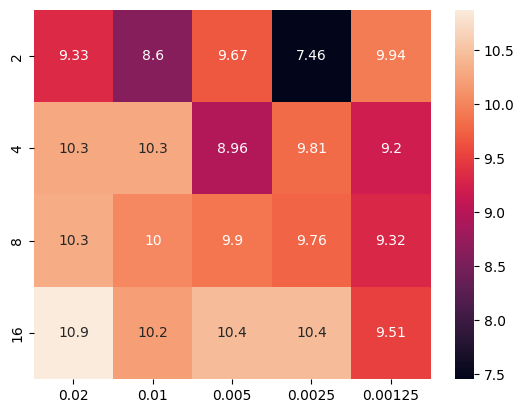

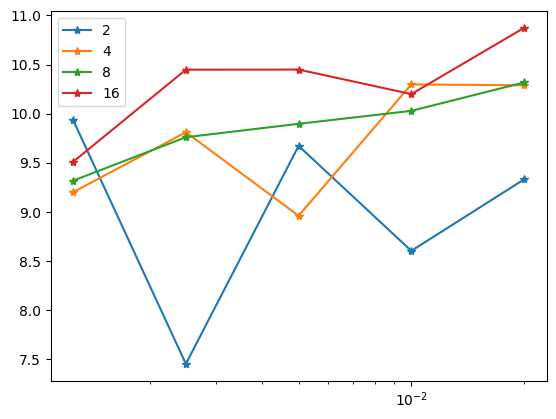

In [ ]:
import seaborn as sns
sns.heatmap(df_beta, annot=True, fmt=".3g")
df_beta.T.plot(marker="*")
plt.xscale("log")

In [ ]:
# from da.optimize import grid_search2
# from da.params import prod_params_kv
# params_kv = prod_params_kv("m", m_list, "h", h_list)
# print(params_kv)
# def evaluate(simulate_params):
#     return compute_beta(model_params, simulate_params)[0]

# df_beta = grid_search2(evaluate, "m", m_list, "h", h_list, n_multi=len(params_kv), multi_type="process")